In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import cmp_to_key
from tqdm import trange
import zipfile

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

# Reading data

In [55]:
def load_stock_quotations(stock_names, filename):
    s = {}
    with zipfile.ZipFile(filename) as z:
        for stock_name in stock_names:
            with z.open(stock_name + '.mst') as f:
                s[stock_name] = pd.read_csv(f, index_col='<DTYYYYMMDD>', parse_dates=True)[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
                s[stock_name].index.rename('time', inplace=True)
                s[stock_name].rename(columns={'<OPEN>':'open', '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'volume'}, inplace=True)
    return pd.concat(s.values(), keys=s.keys(), axis=1)

In [56]:
STOCK_QUOTATIONS_ARCHIVE_FILE_NAME = 'mstall.zip'
STOCK_NAMES_FILE_NAME = 'WIG20.txt'

In [57]:
with open(STOCK_NAMES_FILE_NAME) as f:
    stock_names = list(map(lambda line: line.strip(), f))
stock_names

['ALIOR',
 'ALLEGRO',
 'ASSECOPOL',
 'CCC',
 'CDPROJEKT',
 'CYFRPLSAT',
 'DINOPL',
 'PGNIG',
 'JSW',
 'KGHM',
 'LOTOS',
 'LPP',
 'ORANGEPL',
 'PEKAO',
 'PGE',
 'PKNORLEN',
 'PKOBP',
 'PZU',
 'SANPL',
 'TAURONPE']

In [58]:
number_of_stocks = len(stock_names)

In [59]:
stock_quotations = load_stock_quotations(stock_names, STOCK_QUOTATIONS_ARCHIVE_FILE_NAME)
stock_quotations.fillna(method='ffill', inplace=True)
stock_quotations.tail()

ALIOR                                ALLEGRO                  \
             open   high    low  close    volume    open    high     low   
time                                                                       
2024-01-18  68.90  71.38  68.90  71.02  164430.0  30.450  31.025  30.020   
2024-01-19  70.74  71.20  69.78  69.82  302952.0  30.930  31.510  30.250   
2024-01-22  70.04  71.50  70.02  70.90   67534.0  31.300  31.525  30.120   
2024-01-23  70.80  70.90  69.22  70.48  193284.0  30.535  30.605  29.755   
2024-01-24  71.00  73.10  70.20  71.56  225084.0  30.300  30.630  30.020   

                               ...  SANPL                                 \
             close     volume  ...   open   high    low  close    volume   
time                           ...                                         
2024-01-18  30.590  2118796.0  ...  456.8  463.8  456.8  462.6   71252.0   
2024-01-19  31.510  2721973.0  ...  462.2  470.2  459.6  465.8   58044.0   
2024-01-22  30.225  2506248.0  ...  463.0  473.0  459.0  463.6   81199.0   
2024-01-23  30.000  1541835.0  ...  470.2  474.4  455.0  459.4  108236.0   
2024-01-24  30.520  1271488.0  ...  459.8  464.6  456.6  461.6   68166.0   

           TAURONPE                                  
               open   high    low  close     volume  
time                                                 
2024-01-18    3.420  3.532  3.420  3.500  1706126.0  
2024-01-19    3.481  3.608  3.481  3.596  1882928.0  
2024-01-22    3.630  3.660  3.546  3.597   955919.0  
2024-01-23    3.590  3.597  3.510  3.537   968020.0  
2024-01-24    3.575  3.654  3.551  3.653  1361166.0  

[5 rows x 100 columns]

# Objective function

In [60]:
def semi_covariance(X, Y):
    N = len(X)
    XX, YY = X - X.mean(), Y - Y.mean()
    XX[XX > 0] = 0
    YY[YY > 0] = 0
    return np.sum(XX * YY) / N


def semi_variance(X):
    return semi_covariance(X,X)


def semi_covariance_matrix(X):
    N,M = X.shape
    result = np.empty((M,M))
    for i in range(M):
        for j in range(M):
            result[i,j] = semi_covariance(X[:,i], X[:,j])
    return result

In [61]:
delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
last_returns = stock_returns[-delta_t-1:-1]

stock_returns_mean = last_returns.mean() # predicted return for next day

# variance as risk
stock_returns_var = last_returns.var() # risk
stock_returns_cov = last_returns.cov() # covariance matrix

# semi-variance as risk
stock_returns_semi_var = semi_variance(last_returns)
stock_returns_semi_cov = semi_covariance_matrix(np.array(last_returns))

In [62]:
def portfolio_return_value(X):
    return X @ stock_returns_mean


def portfolio_risk_var(X):
    return np.diag(X @ stock_returns_cov @ X.T)


def portfolio_risk_semi_var(X):
    return np.diag(X @ stock_returns_semi_cov @ X.T)


def portfolio_objective_function(risk_function=portfolio_risk_var,
                                 return_function=portfolio_return_value):
    return lambda X: np.c_[risk_function(X), -return_function(X)]

# NSGA-II Algorithm

Osobnik (chromosom) to wektor $p \in \mathbb{R}^n$, taki że $\sum_{i=1}^n p_i = 1$, którego $i$-ta współrzędna określa jaką część całkowitego kapitału należy zainwestować w $i$-tą spółkę.

### Evolutionary operators

##### Crossover

In [116]:
# to change
# single point crossover, result divided by sum
def single_point_crossover(parents, crossover_probability):
    N,D = parents.shape
    offspring = np.empty((N,D))
    for i in range(int(N/2)):
        if np.random.uniform(0,1) < crossover_probability:
            crossover_point = np.random.randint(1,D)
            offspring[2*i] = np.hstack([parents[2*i, :crossover_point], parents[2*i+1, crossover_point:]])
            offspring[2*i+1] = np.hstack([parents[2*i+1, :crossover_point], parents[2*i, crossover_point:]])
        else:
            offspring[2*i] = parents[2*i]
            offspring[2*i+1] = parents[2*i+1]
    return offspring / offspring.sum(axis=1).reshape(-1,1)


def differential_crossover(F=0.5):
    def _differential_crossover(parents, crossover_probability):
        N,D = parents.shape
        offspring = np.empty((N,D))
        for i in range(int(N/3)):
            if np.random.uniform(0,1) < crossover_probability:
                offspring[3*i] = parents[3*i] + F*(parents[3*i+1] - parents[3*i+2])
                offspring[3*i+1] = parents[3*i+1] + F*(parents[3*i+2] - parents[3*i])
                offspring[3*i+2] = parents[3*i+2] + F*(parents[3*i] - parents[3*i+1])
            else:
                offspring[3*i] = parents[3*i]
                offspring[3*i+1] = parents[3*i+1]
                offspring[3*i+2] = parents[3*i+2]
        offspring = np.abs(offspring)
        return offspring / offspring.sum(axis=1).reshape(-1,1)

    return _differential_crossover

##### Mutation

In [64]:
def change_pair_mutation(population, mutation_probability):
    N,D = population.shape
    for i in range(N):
        if np.random.uniform(0,1) < mutation_probability:
            j,k = np.random.choice(D, size=2, replace=False)
            delta = np.abs(np.random.normal(0, min(population[i,j], 1-population[i,k])/2))
            if population[i,j] - delta >= 0 and population[i,k] + delta <= 1:
                population[i,j] -= delta
                population[i,k] += delta
    return population


def swap_mutation(population, mutation_probability):
    N,D = population.shape
    for i in range(N):
        if np.random.uniform(0,1) < mutation_probability:
            j,k = np.random.choice(D, size=2, replace=False)
            population[i,j], population[i,k] = population[i,k], population[i,j]
    return population

### NSGA-II implementation

In [65]:
def random_population(population_size, chromosome_length):
    population = np.random.random(size=(population_size, chromosome_length))
    return population / population.sum(axis=1).reshape(-1,1)


def dominates(x, y):
    '''Check if x dominates y'''
    return np.all(x <= y) and np.any(x < y)


def fast_nondominated_sorting(values):
    N,M = values.shape

    domination_count = np.zeros(N)
    dominated_elems = [[] for x in range(N)]

    for x in range(N):
        for y in range(x+1, N):
            if dominates(values[x], values[y]):
                dominated_elems[x].append(y)
                domination_count[y] += 1
            elif dominates(values[y], values[x]):
                domination_count[x] += 1
                dominated_elems[y].append(x)

    pareto_front_numbers = np.empty(N)
    current_number = 0
    Q = np.arange(N)[domination_count == 0]

    while Q.size > 0:
        pareto_front_numbers[Q] = current_number
        current_number += 1
        domination_count[Q] = -1
        for x in Q:
            domination_count[dominated_elems[x]] -= 1
        Q = np.arange(N)[domination_count == 0]

    return pareto_front_numbers


def calculate_crowding_distance(values):
    N,M = values.shape
    crowding_distance = np.zeros(N)
    for i in range(M):
        sorted_idx = np.argsort(values[:,i])
        crowding_distance[sorted_idx[[0, -1]]] = 1e40
        for j in range(1, M-1):
            crowding_distance[sorted_idx[j]] += (values[j+1, i] - values[j-1, i])
    return crowding_distance


def rank_population(population_values):
    pareto_front_numbers = fast_nondominated_sorting(population_values)
    crowding_dists = calculate_crowding_distance(population_values)

    def compare(x, y):
        if pareto_front_numbers[x] == pareto_front_numbers[y]:
            return crowding_dists[y] - crowding_dists[x]
        else:
            return pareto_front_numbers[x] - pareto_front_numbers[y]

    return np.array(list(sorted(np.arange(population_values.shape[0]), key=cmp_to_key(compare))))

In [66]:
def nsga2(objective_function,
          chromosome_length=20,
          population_size=100,
          number_of_offspring=200,
          number_of_iterations=100,
          crossover_probability = 0.95,
          mutation_probability = 0.25,
          crossover_operator=single_point_crossover,
          mutation_operator=change_pair_mutation,
          population_generator=random_population,
          alpha=0.5):

    beta = 2-alpha # used for ranking based selection

    # generate initial population
    population = population_generator(population_size=population_size,
                                      chromosome_length=chromosome_length)
    # evaluate initial population
    population_values = objective_function(population)

    for i in trange(number_of_iterations):
        # rank population (first - best, last - worst)
        population_ranking_idx = rank_population(population_values)

        # parent selection (ranking based)
        probabilities = (alpha + (np.arange(population_size-1,-1,-1)/(population_size-1)) * (beta - alpha)) / population_size
        parent_idx = np.random.choice(population_ranking_idx, size=number_of_offspring, replace=True, p=probabilities)

        # crossover
        offspring = crossover_operator(population[parent_idx], crossover_probability)

        # mutation
        offspring = mutation_operator(offspring, mutation_probability)

        # evaluate offspring
        offspring_values = objective_function(offspring)

        # rank population + offspring
        population = np.vstack([population, offspring])
        population_values = np.vstack([population_values, offspring_values])
        population_ranking_idx = rank_population(population_values)

        # select best to create new population
        population_ranking_idx = population_ranking_idx[:population_size]
        population = population[population_ranking_idx]
        population_values = population_values[population_ranking_idx]

    return population[fast_nondominated_sorting(population_values) == 0]
    # return population

# Tests

In [124]:
def show_results(stock_risk=stock_returns_semi_var,
                 objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
                 **kwargs):
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.scatter(stock_risk, stock_returns_mean, c='b')

    nsga2_result = nsga2(objective_function=objective_function,
                         chromosome_length=number_of_stocks,
                         **kwargs)

    pareto_front = objective_function(nsga2_result)
    plt.scatter(pareto_front[:,0], -pareto_front[:,1], c='r')
    plt.legend(['Basic stocks', 'Pareto front'])
    plt.show()

### Variance as risk measure

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


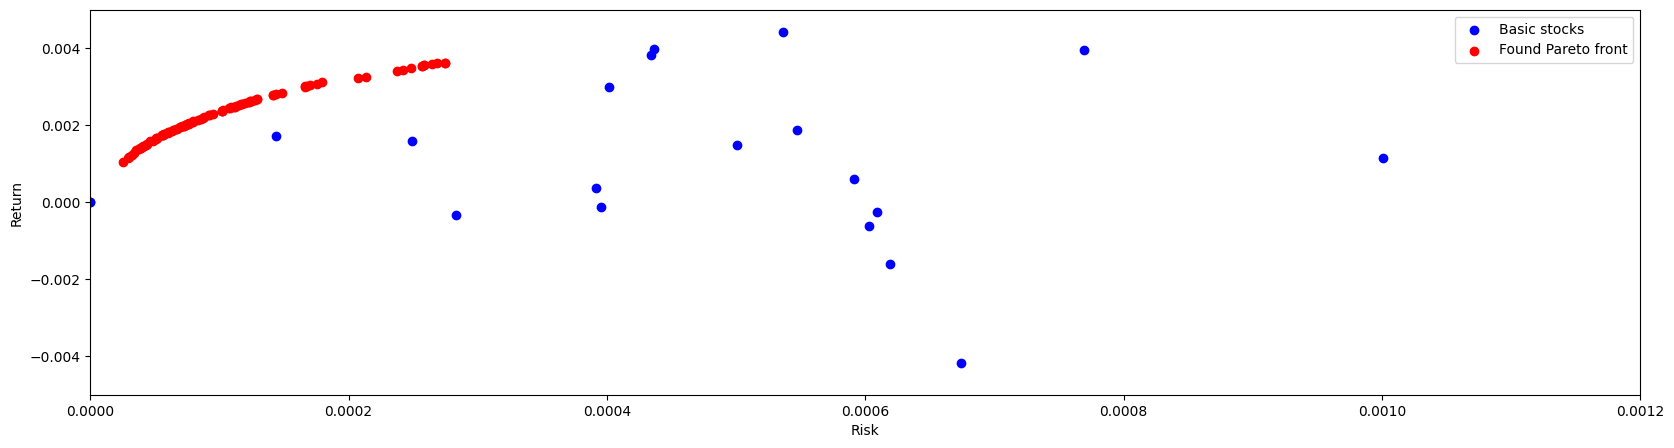

In [114]:
show_results(stock_risk=stock_returns_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_var),
             population_size=100,
             number_of_offspring=200,
             number_of_iterations=100)

100%|██████████| 300/300 [05:05<00:00,  1.02s/it]


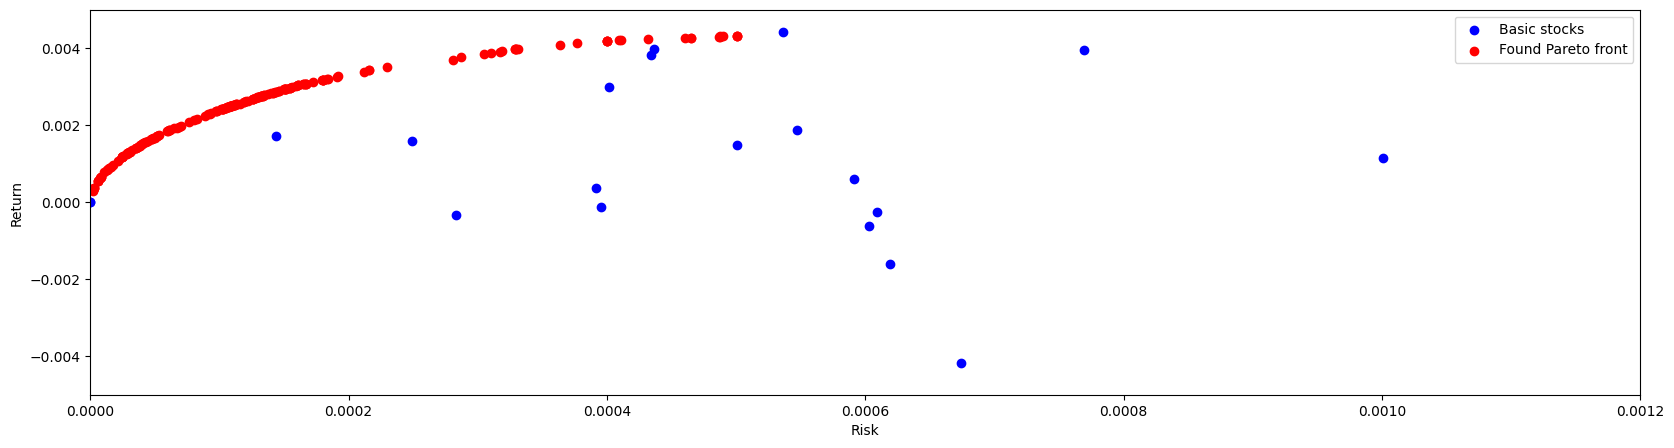

In [115]:
show_results(stock_risk=stock_returns_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=300)

### Semi-variance as risk measure

100%|██████████| 300/300 [01:23<00:00,  3.59it/s]


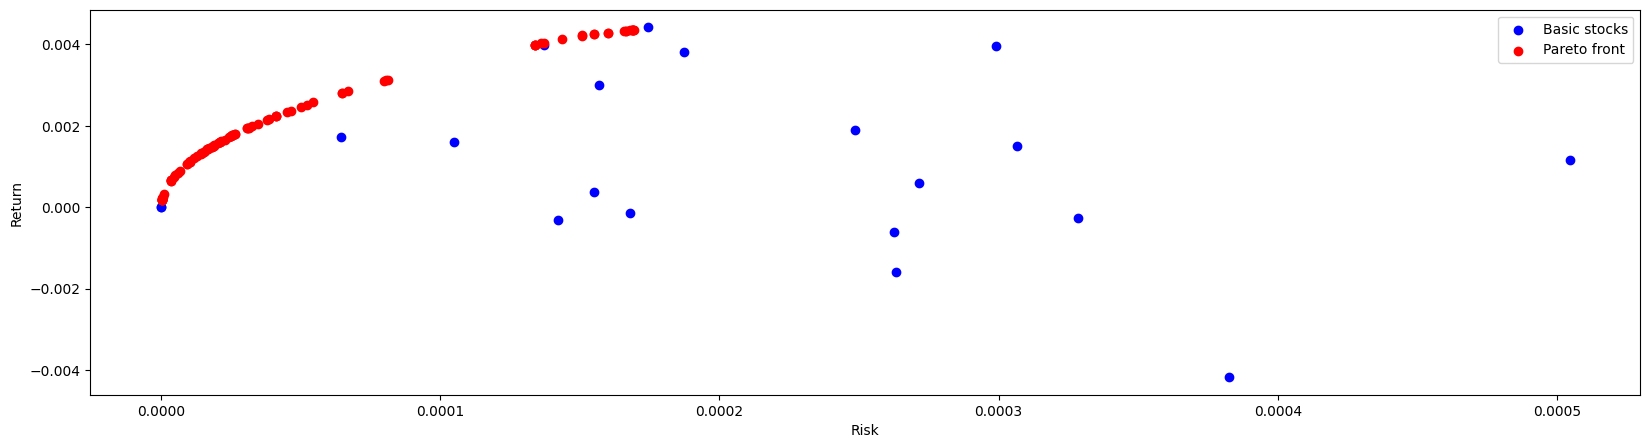

In [18]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=100,
             number_of_offspring=200,
             number_of_iterations=300)

100%|██████████| 400/400 [14:43<00:00,  2.21s/it]


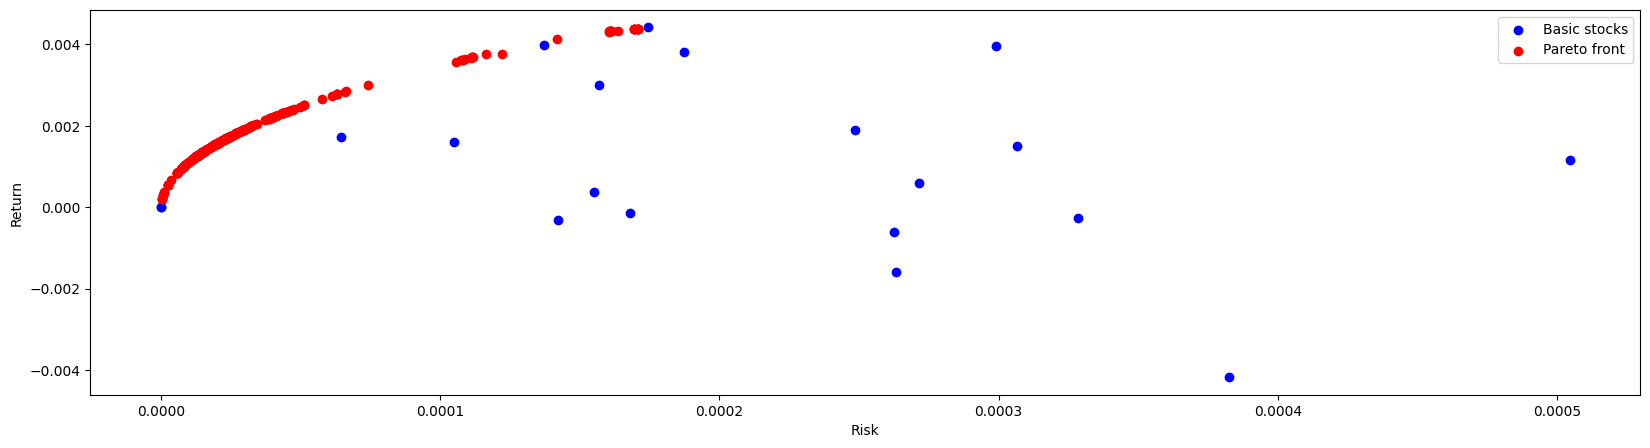

In [19]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=300,
             number_of_offspring=600,
             number_of_iterations=400)

##### Changing alpha parameter

100%|██████████| 400/400 [06:42<00:00,  1.01s/it]


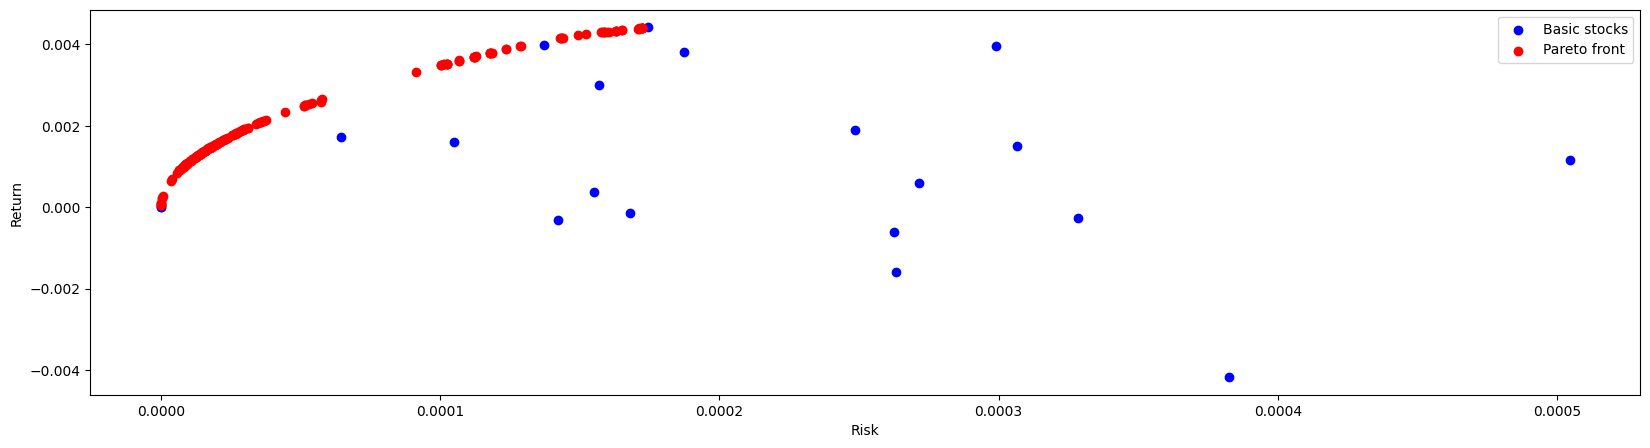

In [44]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             alpha=0.5)

100%|██████████| 400/400 [06:43<00:00,  1.01s/it]


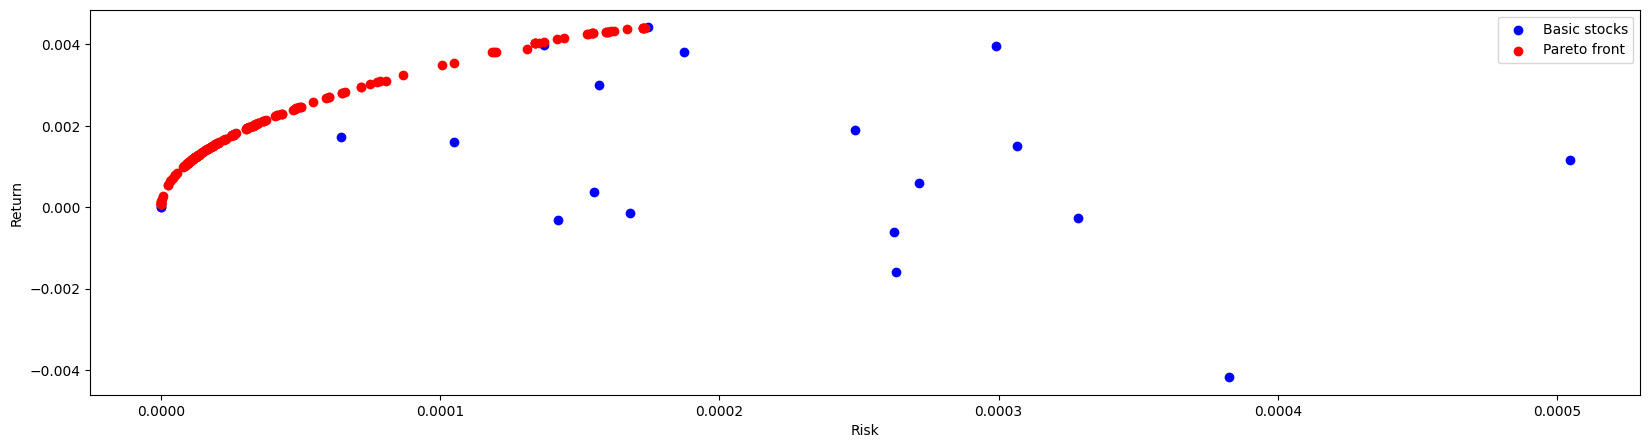

In [45]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             alpha=0.75)

100%|██████████| 400/400 [06:42<00:00,  1.01s/it]


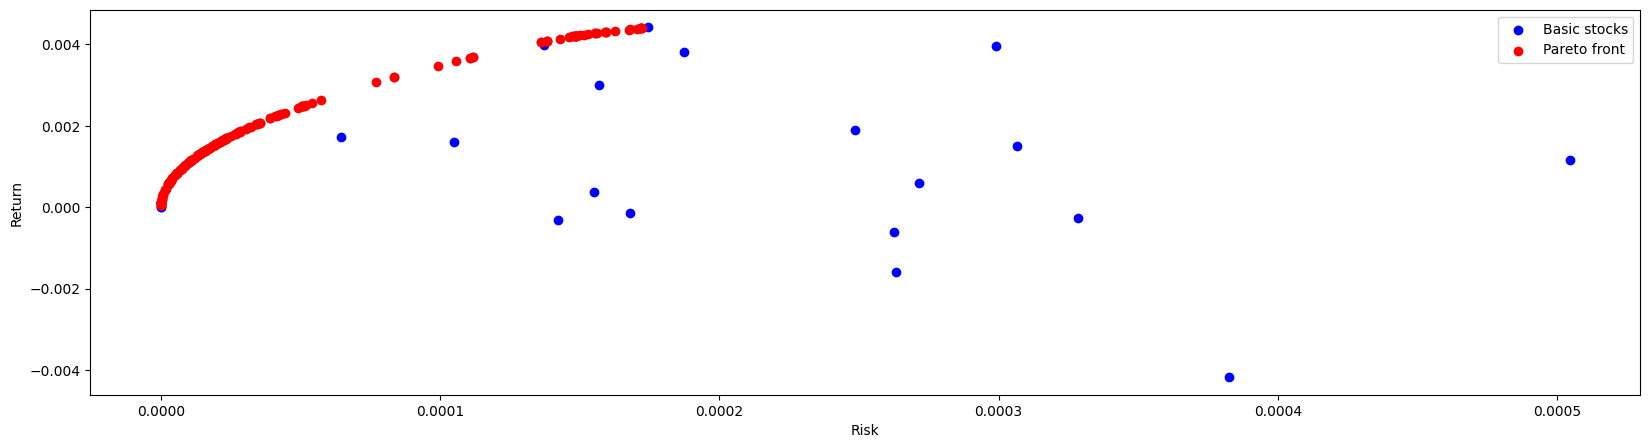

In [46]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             alpha=0.25)

##### Swap mutation

100%|██████████| 400/400 [06:43<00:00,  1.01s/it]


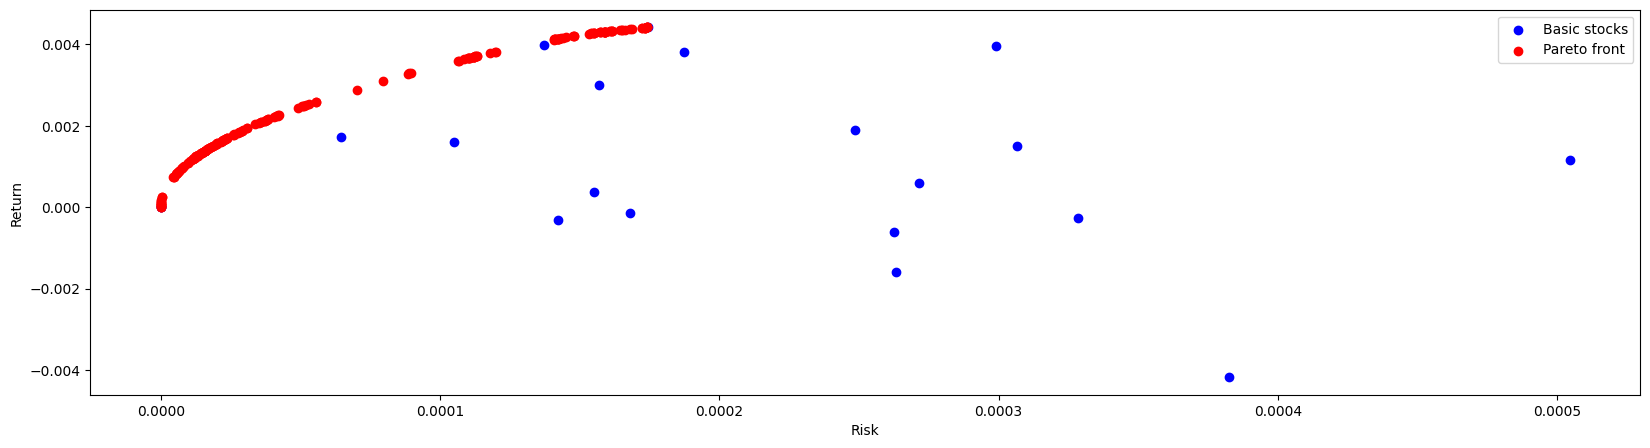

In [47]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             mutation_operator=swap_mutation,
             alpha=0.5)

100%|██████████| 400/400 [06:43<00:00,  1.01s/it]


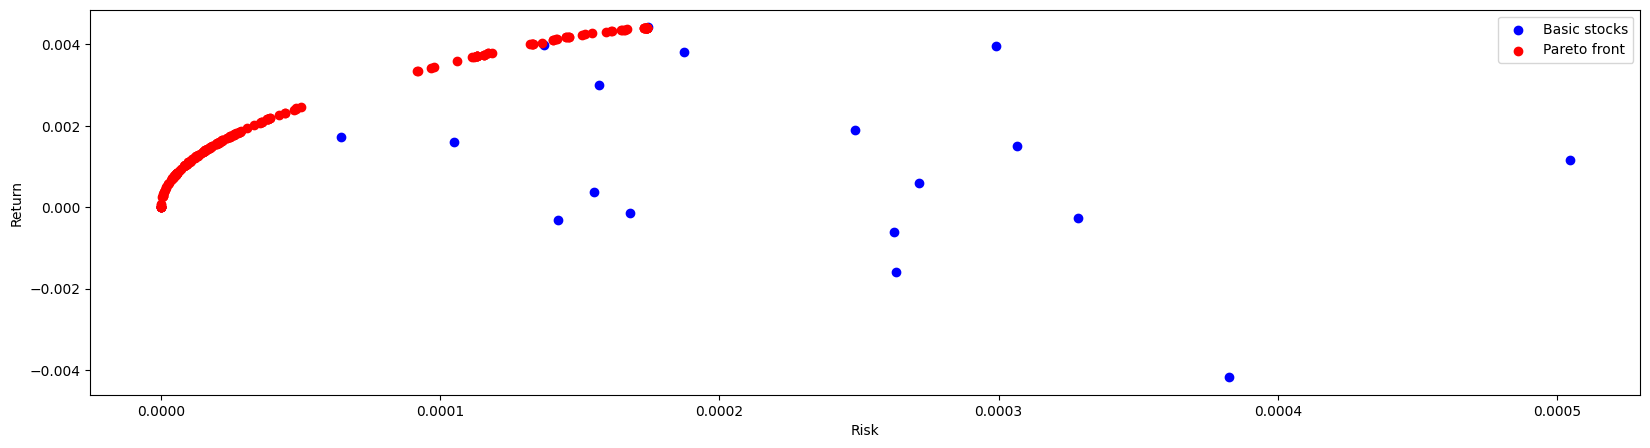

In [48]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             mutation_operator=swap_mutation,
             alpha=0.75)

100%|██████████| 400/400 [06:45<00:00,  1.01s/it]


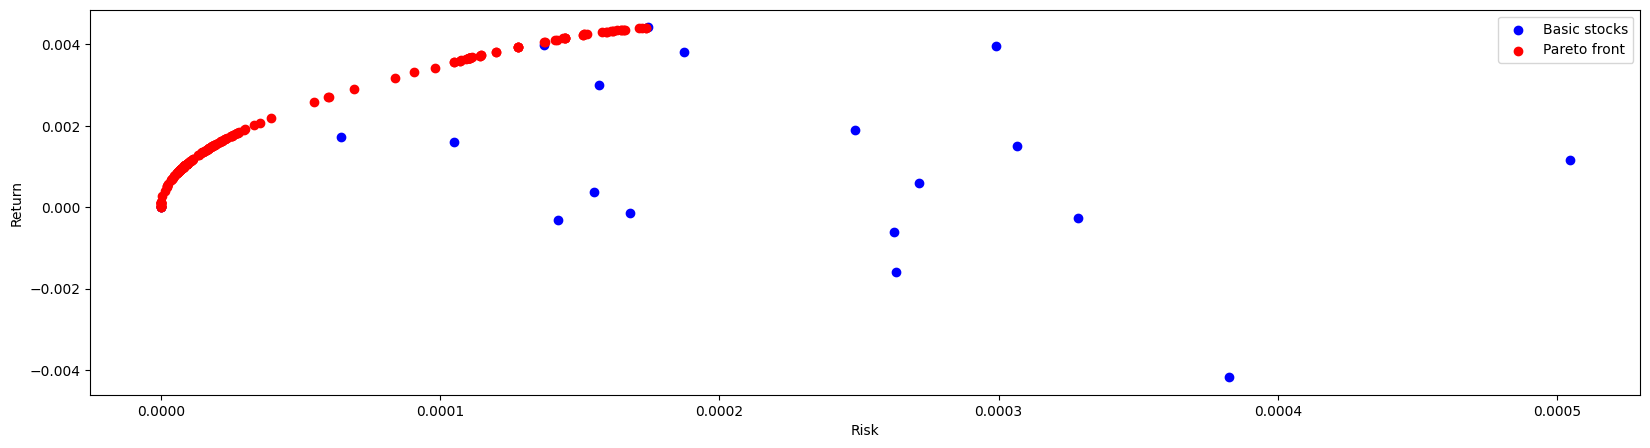

In [49]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             mutation_operator=swap_mutation,
             alpha=0.25)

##### Differential crossover

100%|██████████| 400/400 [06:42<00:00,  1.01s/it]


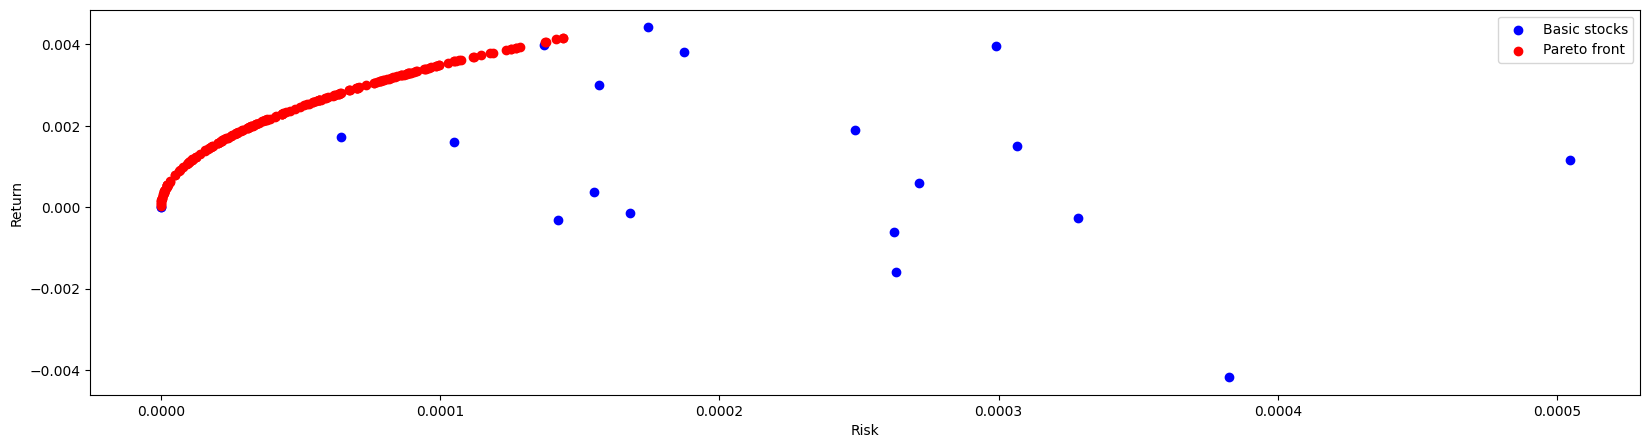

In [126]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             crossover_operator=differential_crossover(0.5),
             alpha=0.75)

100%|██████████| 400/400 [06:40<00:00,  1.00s/it]


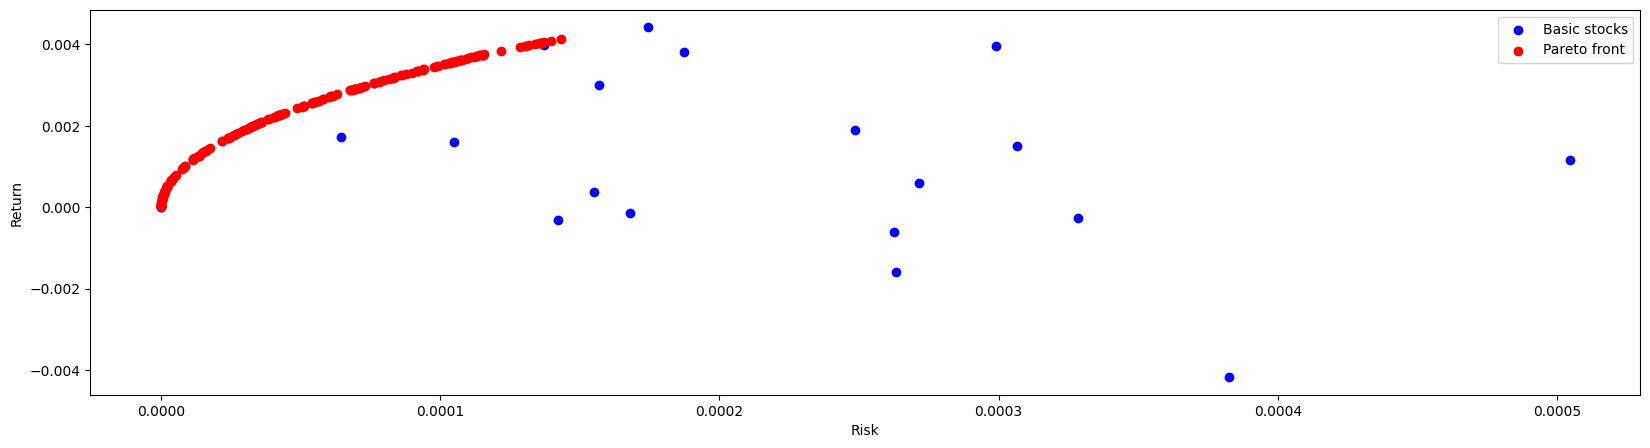

In [127]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             crossover_operator=differential_crossover(0.25),
             alpha=0.75)

100%|██████████| 400/400 [06:39<00:00,  1.00it/s]


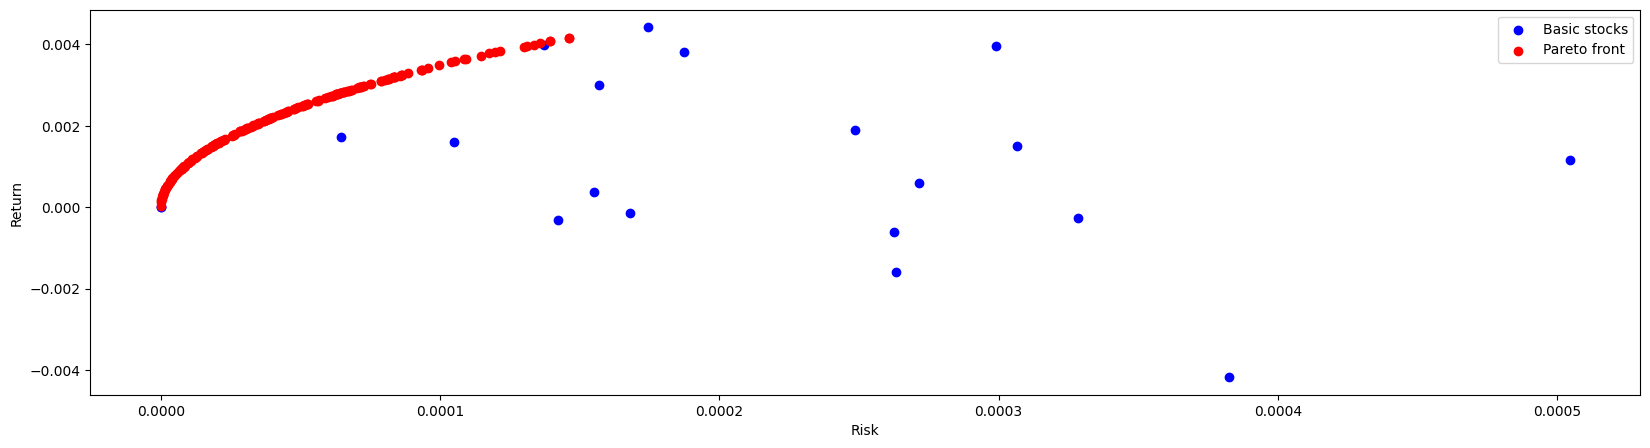

In [128]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             crossover_operator=differential_crossover(0.75),
             alpha=0.75)

100%|██████████| 400/400 [06:41<00:00,  1.00s/it]


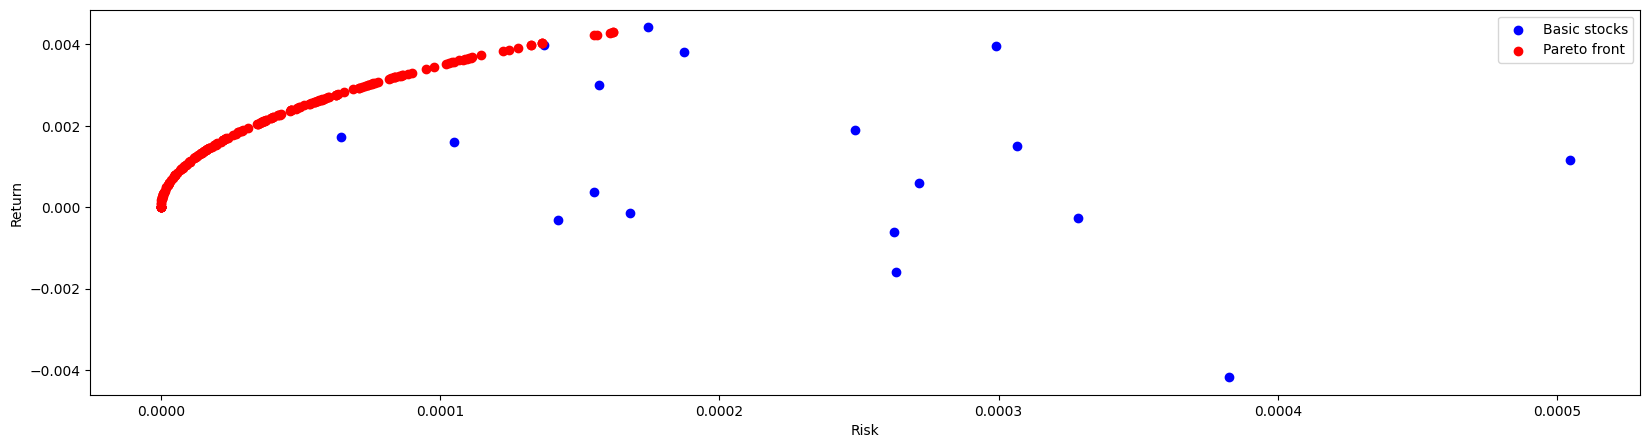

In [129]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             crossover_operator=differential_crossover(0.5),
             mutation_operator=swap_mutation,
             alpha=0.75)

100%|██████████| 400/400 [06:42<00:00,  1.01s/it]


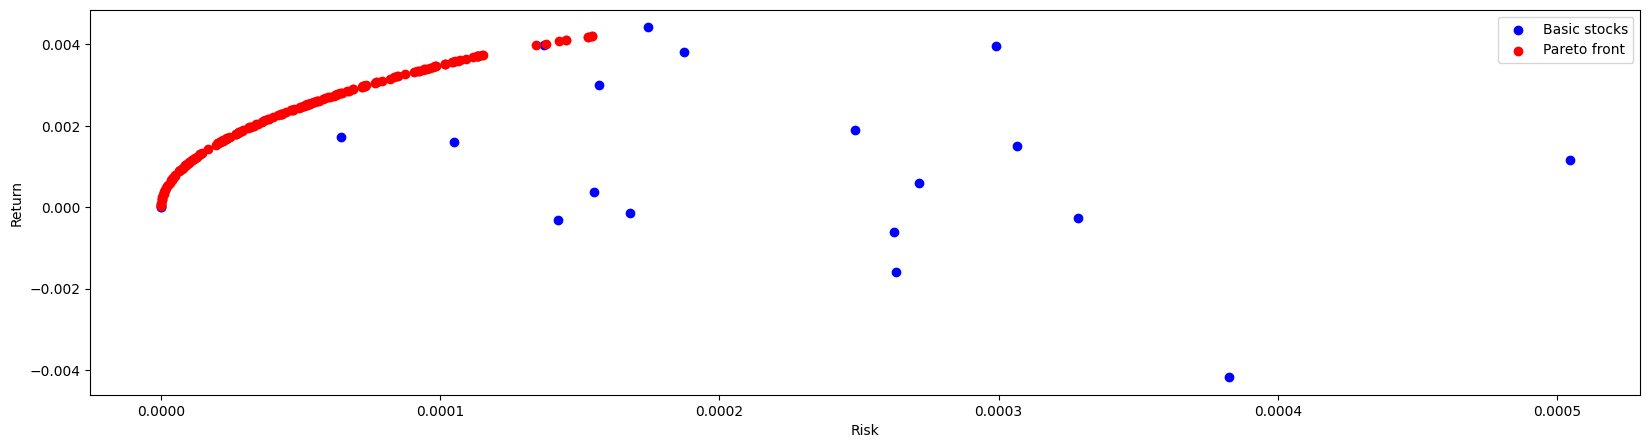

In [130]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             crossover_operator=differential_crossover(0.25),
             mutation_operator=swap_mutation,
             alpha=0.75)

100%|██████████| 400/400 [06:44<00:00,  1.01s/it]


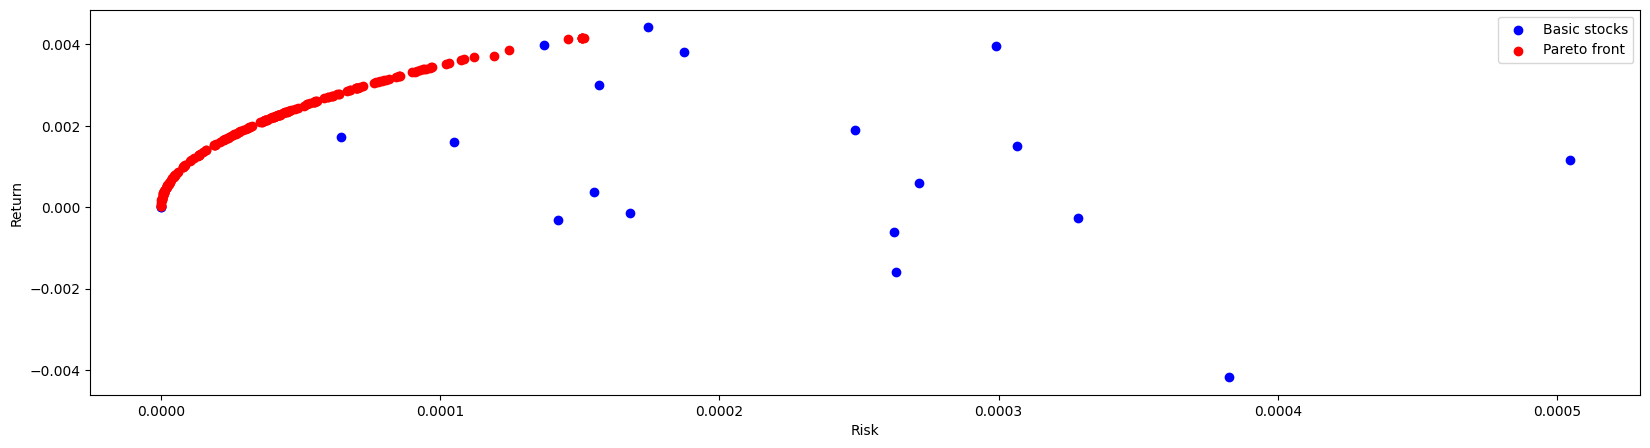

In [131]:
show_results(stock_risk=stock_returns_semi_var,
             objective_function=portfolio_objective_function(risk_function=portfolio_risk_semi_var),
             population_size=200,
             number_of_offspring=400,
             number_of_iterations=400,
             crossover_operator=differential_crossover(0.75),
             mutation_operator=swap_mutation,
             alpha=0.75)